## Importamos librerías

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from tqdm import tqdm
import talib as ta
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from datetime import datetime, timedelta
import nltk
from nltk.corpus import wordnet as wn
import random
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, RandomizedSearchCV
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

/Users/sdiamar/opt/anaconda3/envs/keepcoding/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-12 09:46:48.319229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Descarga de datos

In [2]:
# Descargamos los datos de Yahoo Finance

def download_data_yf(yf_ticker, period):
    stock = yf.Ticker(yf_ticker)
    data = stock.history(period)
    
    return data

In [3]:
# Varias acciones en un mismo dataframe

def download_data_yf(yf_ticker, period):
    stock = yf.Ticker(yf_ticker)
    data = stock.history(period)
    data['Ticker'] = yf_ticker  
    return data

tickers = ['AAPL', 'GOOGL', 'AMZN', 'MSFT']

stock_data = []
for ticker in tickers:
    data = download_data_yf(ticker, period='10y')
    stock_data.append(data)

df = pd.concat(stock_data, axis=0)

In [4]:
# Paso el índice a formato fecha sin hora

df.index = df.index.tz_localize(None).date

In [5]:
# Indicadores técnicos

In [6]:
def calculate_indicators(df):
    # Indicadores técnicos
    df['SMA_20'] = ta.SMA(df['Close'], timeperiod=20)
    df['EMA_50'] = ta.EMA(df['Close'], timeperiod=50)
    df['ADX'] = ta.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['RSI'] = ta.RSI(df['Close'], timeperiod=14)

    # Patrones de velas
    df['CDL_DOJI'] = ta.CDLDOJI(df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_HAMMER'] = ta.CDLHAMMER(
        df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_MORNING_STAR'] = ta.CDLMORNINGSTAR(
        df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_ENGULFING'] = ta.CDLENGULFING(
        df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_LONGLINE'] = ta.CDLLONGLINE(
        df['Open'], df['High'], df['Low'], df['Close'])

    # Otros indicadores adicionales para medir la volatilidad
    df['bb_bbh'], df['bb_bbm'], df['bb_bbl'] = ta.BBANDS(df['Close'], timeperiod=20,
                   nbdevup=2, nbdevdn=2, matype=0)
    df['daily_return'] = df['Close'].pct_change()
    df['macd'], df['macd_signal'], df['macd_hist'] = ta.MACD(df['Close'], slowperiod=26,
                   fastperiod=12, signalperiod=9)
    df['stoch'], df['stoch_d'] = ta.STOCH(
        high=df['High'], low=df['Low'], close=df['Close'], fastk_period=21, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Volatility'] = df['Log_Return'].rolling(window=5).std() # Volatilidad a 5 días
    df['Volume_Change'] = df['Volume'].pct_change() 

    # Añadimos la variable a predecir
    df['Tomorrow Close'] = df['Close'].shift(-1)
    
    return df

In [7]:
df = df.groupby('Ticker', group_keys=False).apply(calculate_indicators)

# Mostrar el DataFrame final
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,SMA_20,EMA_50,...,daily_return,macd,macd_signal,macd_hist,stoch,stoch_d,Log_Return,Volatility,Volume_Change,Tomorrow Close
2014-09-12,22.466273,22.683811,22.437417,22.566164,250504400,0.0,0.0,AAPL,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.559505
2014-09-15,22.821438,22.874714,22.517331,22.559505,245266000,0.0,0.0,AAPL,NaN,NaN,...,-0.000295,NaN,NaN,NaN,NaN,NaN,-0.000295,NaN,-0.020911,22.388580
2014-09-16,22.153285,22.477371,21.951286,22.388580,267632400,0.0,0.0,AAPL,NaN,NaN,...,-0.007577,NaN,NaN,NaN,NaN,NaN,-0.007605,NaN,0.091192,22.548405
2014-09-17,22.479591,22.597240,22.328646,22.548405,243706000,0.0,0.0,AAPL,NaN,NaN,...,0.007139,NaN,NaN,NaN,NaN,NaN,0.007113,NaN,-0.089400,22.595020
2014-09-18,22.626097,22.719327,22.543965,22.595020,149197600,0.0,0.0,AAPL,NaN,NaN,...,0.002067,NaN,NaN,NaN,NaN,NaN,0.002065,NaN,-0.387797,22.410778


In [8]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,SMA_20,EMA_50,...,daily_return,macd,macd_signal,macd_hist,stoch,stoch_d,Log_Return,Volatility,Volume_Change,Tomorrow Close
2024-09-05,407.619995,413.100006,406.130005,408.390015,14195500,0.0,0.0,MSFT,413.996909,420.933530,...,-0.001247,-3.552037,-3.632404,0.080367,45.923423,57.413044,-0.001248,0.010907,-0.062124,401.700012
2024-09-06,409.059998,410.649994,400.799988,401.700012,19609500,0.0,0.0,MSFT,413.983635,420.179275,...,-0.016381,-4.175649,-3.741053,-0.434596,29.389533,44.660200,-0.016517,0.011831,0.381388,405.720001
2024-09-09,407.239990,408.649994,402.149994,405.720001,15295100,0.0,0.0,MSFT,414.005161,419.612244,...,0.010007,-4.295965,-3.852036,-0.443930,22.220891,32.511282,0.009958,0.011919,-0.220016,414.200012
2024-09-10,408.200012,416.329987,407.700012,414.200012,19594300,0.0,0.0,MSFT,414.411258,419.400000,...,0.020901,-3.664805,-3.814590,0.149784,26.494213,26.034879,0.020686,0.013932,0.281083,423.040009
2024-09-11,415.500000,423.989990,409.579987,423.040009,19233600,0.0,0.0,MSFT,414.900002,419.542745,...,0.021342,-2.423357,-3.536343,1.112986,52.020041,33.578381,0.021118,0.015939,-0.018408,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10064 entries, 2014-09-12 to 2024-09-11
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              10064 non-null  float64
 1   High              10064 non-null  float64
 2   Low               10064 non-null  float64
 3   Close             10064 non-null  float64
 4   Volume            10064 non-null  int64  
 5   Dividends         10064 non-null  float64
 6   Stock Splits      10064 non-null  float64
 7   Ticker            10064 non-null  object 
 8   SMA_20            9988 non-null   float64
 9   EMA_50            9868 non-null   float64
 10  ADX               9956 non-null   float64
 11  RSI               10008 non-null  float64
 12  CDL_DOJI          10064 non-null  int32  
 13  CDL_HAMMER        10064 non-null  int32  
 14  CDL_MORNING_STAR  10064 non-null  int32  
 15  CDL_ENGULFING     10064 non-null  int32  
 16  CDL_LONGLINE      10064 non-nul

In [10]:
# Contar los valores nulos por cada Ticker
nulos_por_ticker = df.groupby('Ticker').apply(lambda x: x.isnull().sum())

# Mostrar el resultado
nulos_por_ticker
# Comprobamos que hemos hecho los calculos para cada accion

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,SMA_20,EMA_50,...,daily_return,macd,macd_signal,macd_hist,stoch,stoch_d,Log_Return,Volatility,Volume_Change,Tomorrow Close
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0,0,0,0,0,0,0,0,19,49,...,1,33,33,33,24,24,1,5,1,1
AMZN,0,0,0,0,0,0,0,0,19,49,...,1,33,33,33,24,24,1,5,1,1
GOOGL,0,0,0,0,0,0,0,0,19,49,...,1,33,33,33,24,24,1,5,1,1
MSFT,0,0,0,0,0,0,0,0,19,49,...,1,33,33,33,24,24,1,5,1,1


In [11]:
# Noticias

In [12]:
# Ejemplo con Yahoo
ticker = yf.Ticker("AAPL")

# Noticias recientes de la última semana
news = ticker.news
news_df = pd.DataFrame(news)
news_df['providerPublishTime'] = pd.to_datetime(news_df['providerPublishTime'], unit='s')
news_df = news_df.sort_values(by='providerPublishTime', ascending=False)
news_df = news_df[['providerPublishTime', 'title', 'publisher', 'link']]

news_df

,providerPublishTime,title,publisher,link
0,2024-09-12 05:18:12,Is Apple Inc. (AAPL) The Most Buzzing Stock To...,Insider Monkey,https://finance.yahoo.com/news/apple-inc-aapl-...
1,2024-09-11 22:16:42,Apple's new AirPods Pro double as hearing aids,Fox Business,https://finance.yahoo.com/news/apples-airpods-...
2,2024-09-11 21:37:16,China Is Eating Apple's Lunch: Where Smartphon...,Benzinga,https://finance.yahoo.com/news/china-eating-ap...
3,2024-09-11 21:26:23,Apple’s big health updates are impressive and ...,Yahoo Finance,https://finance.yahoo.com/news/apples-big-heal...
4,2024-09-11 21:21:49,Here's Why Analysts Think iPhone 16 Sales Coul...,Investopedia,https://finance.yahoo.com/m/6ac33ed3-db77-3a8b...
5,2024-09-11 21:07:05,Billionaire Stanley Druckenmiller Dumps Apple ...,Insider Monkey,https://finance.yahoo.com/news/billionaire-sta...
6,2024-09-11 20:23:09,Arm Holdings Stock Called 'Top Pick' On Edge A...,Investor's Business Daily,https://finance.yahoo.com/m/ed980326-8040-3dfa...
7,2024-09-11 20:23:05,Apple Inc. (NASDAQ:AAPL)’s iPhone Upgrade Cycl...,Insider Monkey,https://finance.yahoo.com/news/apple-inc-nasda...


In [13]:
# Función de sentimiento de noticias con el modelo pre-entrenado de Hugging Face finbert
def perform_sentiment_analysis(texts):
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment_score = probabilities[0][2].item() - probabilities[0][0].item()  # Positive - Negative
        results.append(sentiment_score)
    
    return results

In [14]:
# Generamos noticias sintéticas para el resto del año
nltk.download('wordnet', quiet=True)

def get_synonyms(word, pos):
    synsets = wn.synsets(word, pos=pos)
    return list(set([lemma.name() for synset in synsets for lemma in synset.lemmas()]))

def generate_news_titles(row):
    price_change = row['Close'] - row['Open']
    percent_change = (price_change / row['Open']) * 100
    
    templates = [
        "{stock} stock {movement} {percent}% as {market_condition}",
        "Investors {reaction} as {stock} shares {movement} ${price_change}",
        "{stock} {performance} in {volume} trading session",
        "{market_condition} leads to {movement} in {stock} stock",
        "{stock} shares {movement} amid {market_factor}"
    ]
    
    movement_words = get_synonyms('increase', 'v') if price_change > 0 else get_synonyms('decrease', 'v')
    reaction_words = get_synonyms('optimistic', 'a') if price_change > 0 else get_synonyms('pessimistic', 'a')
    performance_words = get_synonyms('excel', 'v') if price_change > 0 else get_synonyms('struggle', 'v')
    volume_words = ['high-volume', 'active', 'busy', 'low-volume', 'quiet', 'subdued']
    market_conditions = ['market volatility', 'economic uncertainty', 'sector trends', 'global factors']
    market_factors = ['earnings expectations', 'analyst reports', 'industry news', 'technological advancements']
    
    num_titles = random.randint(1, 1)
    titles = []
    for _ in range(num_titles):
        headline = random.choice(templates).format(
            movement=random.choice(movement_words).replace('_', ' '),
            percent=abs(round(percent_change, 2)),
            price_change=abs(round(price_change, 2)),
            market_condition=random.choice(market_conditions),
            reaction=random.choice(reaction_words).replace('_', ' '),
            performance=random.choice(performance_words).replace('_', ' '),
            volume=random.choice(volume_words),
            market_factor=random.choice(market_factors),
            stock=row['Ticker']  
        )
        titles.append(headline)
    
    return titles

def generate_news_dataframe(df):
    all_news = []
    for date, row in df.iterrows():
        titles = generate_news_titles(row)  # Generar titulares para cada fila
        for title in titles:
            all_news.append({
                'Date': date, 
                'News_Title': title, 
                'Ticker': row['Ticker']  # Asociar el ticker de la fila correspondiente
            })

    news_df = pd.DataFrame(all_news) 
    return news_df

news_sint = generate_news_dataframe(df)
news_sint

,Date,News_Title,Ticker
0,2014-09-12,AAPL shares increase amid earnings expectations,AAPL
1,2014-09-15,Investors pessimistic as AAPL shares minify $0.26,AAPL
2,2014-09-16,Investors affirmative as AAPL shares increase ...,AAPL
3,2014-09-17,AAPL shares increase amid analyst reports,AAPL
4,2014-09-18,AAPL shares lessen amid analyst reports,AAPL
...,...,...,...
10059,2024-09-05,Investors affirmative as MSFT shares increase ...,MSFT
10060,2024-09-06,market volatility leads to diminish in MSFT stock,MSFT
10061,2024-09-09,Investors pessimistic as MSFT shares decrease ...,MSFT
10062,2024-09-10,Investors optimistic as MSFT shares increase $6.0,MSFT


In [15]:
# Analizamos el sentimiento de las noticias sintéticas creadas

text_column = 'News_Title'  

sentiment_scores = perform_sentiment_analysis(news_sint[text_column])
news_sint['sentiment_score'] = sentiment_scores
news_sint['sentiment'] = pd.cut(news_sint['sentiment_score'], 
                              bins=[-np.inf, -0.05, 0.05, np.inf], 
                              labels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])

print("\nSentiment Distribution:")
print(news_sint['sentiment'].value_counts(normalize=True))


Sentiment Distribution:
sentiment
NEGATIVE    0.547595
NEUTRAL     0.304650
POSITIVE    0.147754
Name: proportion, dtype: float64


In [16]:
news_sint

,Date,News_Title,Ticker,sentiment_score,sentiment
0,2014-09-12,AAPL shares increase amid earnings expectations,AAPL,-0.919731,NEGATIVE
1,2014-09-15,Investors pessimistic as AAPL shares minify $0.26,AAPL,0.012215,NEUTRAL
2,2014-09-16,Investors affirmative as AAPL shares increase ...,AAPL,-0.893370,NEGATIVE
3,2014-09-17,AAPL shares increase amid analyst reports,AAPL,-0.877413,NEGATIVE
4,2014-09-18,AAPL shares lessen amid analyst reports,AAPL,-0.029867,NEUTRAL
...,...,...,...,...,...
10059,2024-09-05,Investors affirmative as MSFT shares increase ...,MSFT,-0.874199,NEGATIVE
10060,2024-09-06,market volatility leads to diminish in MSFT stock,MSFT,-0.232476,NEGATIVE
10061,2024-09-09,Investors pessimistic as MSFT shares decrease ...,MSFT,0.011706,NEUTRAL
10062,2024-09-10,Investors optimistic as MSFT shares increase $6.0,MSFT,-0.910367,NEGATIVE


In [17]:
# Agrupamos datos por ticker
grouped_sint = news_sint.groupby('Ticker')

agg_sint = pd.DataFrame({
        'positive_sentiment': grouped_sint.apply(lambda x: x[x['sentiment'] == 'POSITIVE']['sentiment_score']),
        'negative_sentiment': grouped_sint.apply(lambda x: x[x['sentiment'] == 'NEGATIVE']['sentiment_score']),
        'neutral_sentiment': grouped_sint.apply(lambda x: x[x['sentiment'] == 'NEUTRAL']['sentiment_score']),
    })

agg_sint = agg_sint.fillna(0)
conditions = [
    (agg_sint['positive_sentiment'] != 0),
    (agg_sint['negative_sentiment'] != 0),
    (agg_sint['neutral_sentiment'] != 0)
]

choices = [1, -1, 0]
agg_sint['sentiment_indicator'] = np.select(conditions, choices, default=0)

In [18]:
# Combinamos noticias con el resto de datos

def combine_stock_and_news(stock_df, sentiment_df):
    sentiment_df = sentiment_df.reset_index()
    if 'Ticker' not in stock_df.columns:
        raise ValueError("El DataFrame de acciones no tiene la columna 'Ticker'")
    
    sentiment_df['sequence'] = sentiment_df.groupby('Ticker').cumcount()
    
    stock_df = stock_df.reset_index(drop=True)  # Reseteamos el índice en el stock_df
    stock_df['sequence'] = stock_df.groupby('Ticker').cumcount()  # Crear la secuencia

    final_df = pd.merge(stock_df, sentiment_df, left_on=['Ticker', 'sequence'], right_on=['Ticker', 'sequence'], how='left')

    final_df['sentiment_indicator'] = final_df['sentiment_indicator'].ffill()

    final_df.drop(columns=['level_1'], inplace=True, errors='ignore')  # Eliminar duplicados si hay

    return final_df

final_df = combine_stock_and_news(df, agg_sint)

final_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,SMA_20,EMA_50,...,stoch_d,Log_Return,Volatility,Volume_Change,Tomorrow Close,sequence,positive_sentiment,negative_sentiment,neutral_sentiment,sentiment_indicator
10059,407.619995,413.100006,406.130005,408.390015,14195500,0.0,0.0,MSFT,413.996909,420.933530,...,57.413044,-0.001248,0.010907,-0.062124,401.700012,2511,0.000000,-0.874199,0.000000,-1
10060,409.059998,410.649994,400.799988,401.700012,19609500,0.0,0.0,MSFT,413.983635,420.179275,...,44.660200,-0.016517,0.011831,0.381388,405.720001,2512,0.000000,-0.232476,0.000000,-1
10061,407.239990,408.649994,402.149994,405.720001,15295100,0.0,0.0,MSFT,414.005161,419.612244,...,32.511282,0.009958,0.011919,-0.220016,414.200012,2513,0.000000,0.000000,0.011706,0
10062,408.200012,416.329987,407.700012,414.200012,19594300,0.0,0.0,MSFT,414.411258,419.400000,...,26.034879,0.020686,0.013932,0.281083,423.040009,2514,0.000000,-0.910367,0.000000,-1
10063,415.500000,423.989990,409.579987,423.040009,19233600,0.0,0.0,MSFT,414.900002,419.542745,...,33.578381,0.021118,0.015939,-0.018408,NaN,2515,0.762728,0.000000,0.000000,1


In [19]:
final_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,SMA_20,EMA_50,...,stoch_d,Log_Return,Volatility,Volume_Change,Tomorrow Close,sequence,positive_sentiment,negative_sentiment,neutral_sentiment,sentiment_indicator
10059,407.619995,413.100006,406.130005,408.390015,14195500,0.0,0.0,MSFT,413.996909,420.933530,...,57.413044,-0.001248,0.010907,-0.062124,401.700012,2511,0.000000,-0.874199,0.000000,-1
10060,409.059998,410.649994,400.799988,401.700012,19609500,0.0,0.0,MSFT,413.983635,420.179275,...,44.660200,-0.016517,0.011831,0.381388,405.720001,2512,0.000000,-0.232476,0.000000,-1
10061,407.239990,408.649994,402.149994,405.720001,15295100,0.0,0.0,MSFT,414.005161,419.612244,...,32.511282,0.009958,0.011919,-0.220016,414.200012,2513,0.000000,0.000000,0.011706,0
10062,408.200012,416.329987,407.700012,414.200012,19594300,0.0,0.0,MSFT,414.411258,419.400000,...,26.034879,0.020686,0.013932,0.281083,423.040009,2514,0.000000,-0.910367,0.000000,-1
10063,415.500000,423.989990,409.579987,423.040009,19233600,0.0,0.0,MSFT,414.900002,419.542745,...,33.578381,0.021118,0.015939,-0.018408,NaN,2515,0.762728,0.000000,0.000000,1


In [20]:
encoded_tickers = pd.get_dummies(final_df['Ticker'])
encoded_tickers = encoded_tickers.astype(int)
final_df = pd.concat([final_df, encoded_tickers], axis=1)
final_df.drop(['Ticker','sequence'], axis=1, inplace=True)

In [21]:
final_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,EMA_50,ADX,...,Volume_Change,Tomorrow Close,positive_sentiment,negative_sentiment,neutral_sentiment,sentiment_indicator,AAPL,AMZN,GOOGL,MSFT
0,22.466273,22.683811,22.437417,22.566164,250504400,0.0,0.0,NaN,NaN,NaN,...,NaN,22.559505,0.000000,-0.919731,0.000000,-1,1,0,0,0
1,22.821438,22.874714,22.517331,22.559505,245266000,0.0,0.0,NaN,NaN,NaN,...,-0.020911,22.388580,0.000000,0.000000,0.012215,0,1,0,0,0
2,22.153285,22.477371,21.951286,22.388580,267632400,0.0,0.0,NaN,NaN,NaN,...,0.091192,22.548405,0.000000,-0.893370,0.000000,-1,1,0,0,0
3,22.479591,22.597240,22.328646,22.548405,243706000,0.0,0.0,NaN,NaN,NaN,...,-0.089400,22.595020,0.000000,-0.877413,0.000000,-1,1,0,0,0
4,22.626097,22.719327,22.543965,22.595020,149197600,0.0,0.0,NaN,NaN,NaN,...,-0.387797,22.410778,0.000000,0.000000,-0.029867,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10059,407.619995,413.100006,406.130005,408.390015,14195500,0.0,0.0,413.996909,420.933530,21.098276,...,-0.062124,401.700012,0.000000,-0.874199,0.000000,-1,0,0,0,1
10060,409.059998,410.649994,400.799988,401.700012,19609500,0.0,0.0,413.983635,420.179275,21.498964,...,0.381388,405.720001,0.000000,-0.232476,0.000000,-1,0,0,0,1
10061,407.239990,408.649994,402.149994,405.720001,15295100,0.0,0.0,414.005161,419.612244,21.871031,...,-0.220016,414.200012,0.000000,0.000000,0.011706,0,0,0,0,1
10062,408.200012,416.329987,407.700012,414.200012,19594300,0.0,0.0,414.411258,419.400000,20.847686,...,0.281083,423.040009,0.000000,-0.910367,0.000000,-1,0,0,0,1


### --> Ya tenemos nuestro dataframe completo y ahora vamos a trabajarlo.

## Análisis exploratorio y Preprocesamiento: Dividimos datos en train y test

In [22]:
df_aapl = final_df[final_df['AAPL'] == 1]
df_amzn = final_df[final_df['AMZN'] == 1]
df_googl = final_df[final_df['GOOGL'] == 1]
df_msft = final_df[final_df['MSFT'] == 1]

# Ahora combinamos 3 acciones para el entrenamiento
train = pd.concat([df_aapl, df_amzn, df_googl])  # Entrenamos con AAPL, AMZN y GOOGL

# Dejamos la 4ª acción (MSFT) para evaluar
test = df_msft  # Test con MSFT

print(f"Dimensiones del conjunto de training: {train.shape}")
print(f"Dimensiones del conjunto de test: {test.shape}")

train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

Dimensiones del conjunto de training: (7548, 37)
Dimensiones del conjunto de test: (2516, 37)


In [23]:
# Leemos train
df_train = pd.read_csv('./train.csv', sep=';', decimal='.')

In [24]:
# Matriz de correlación

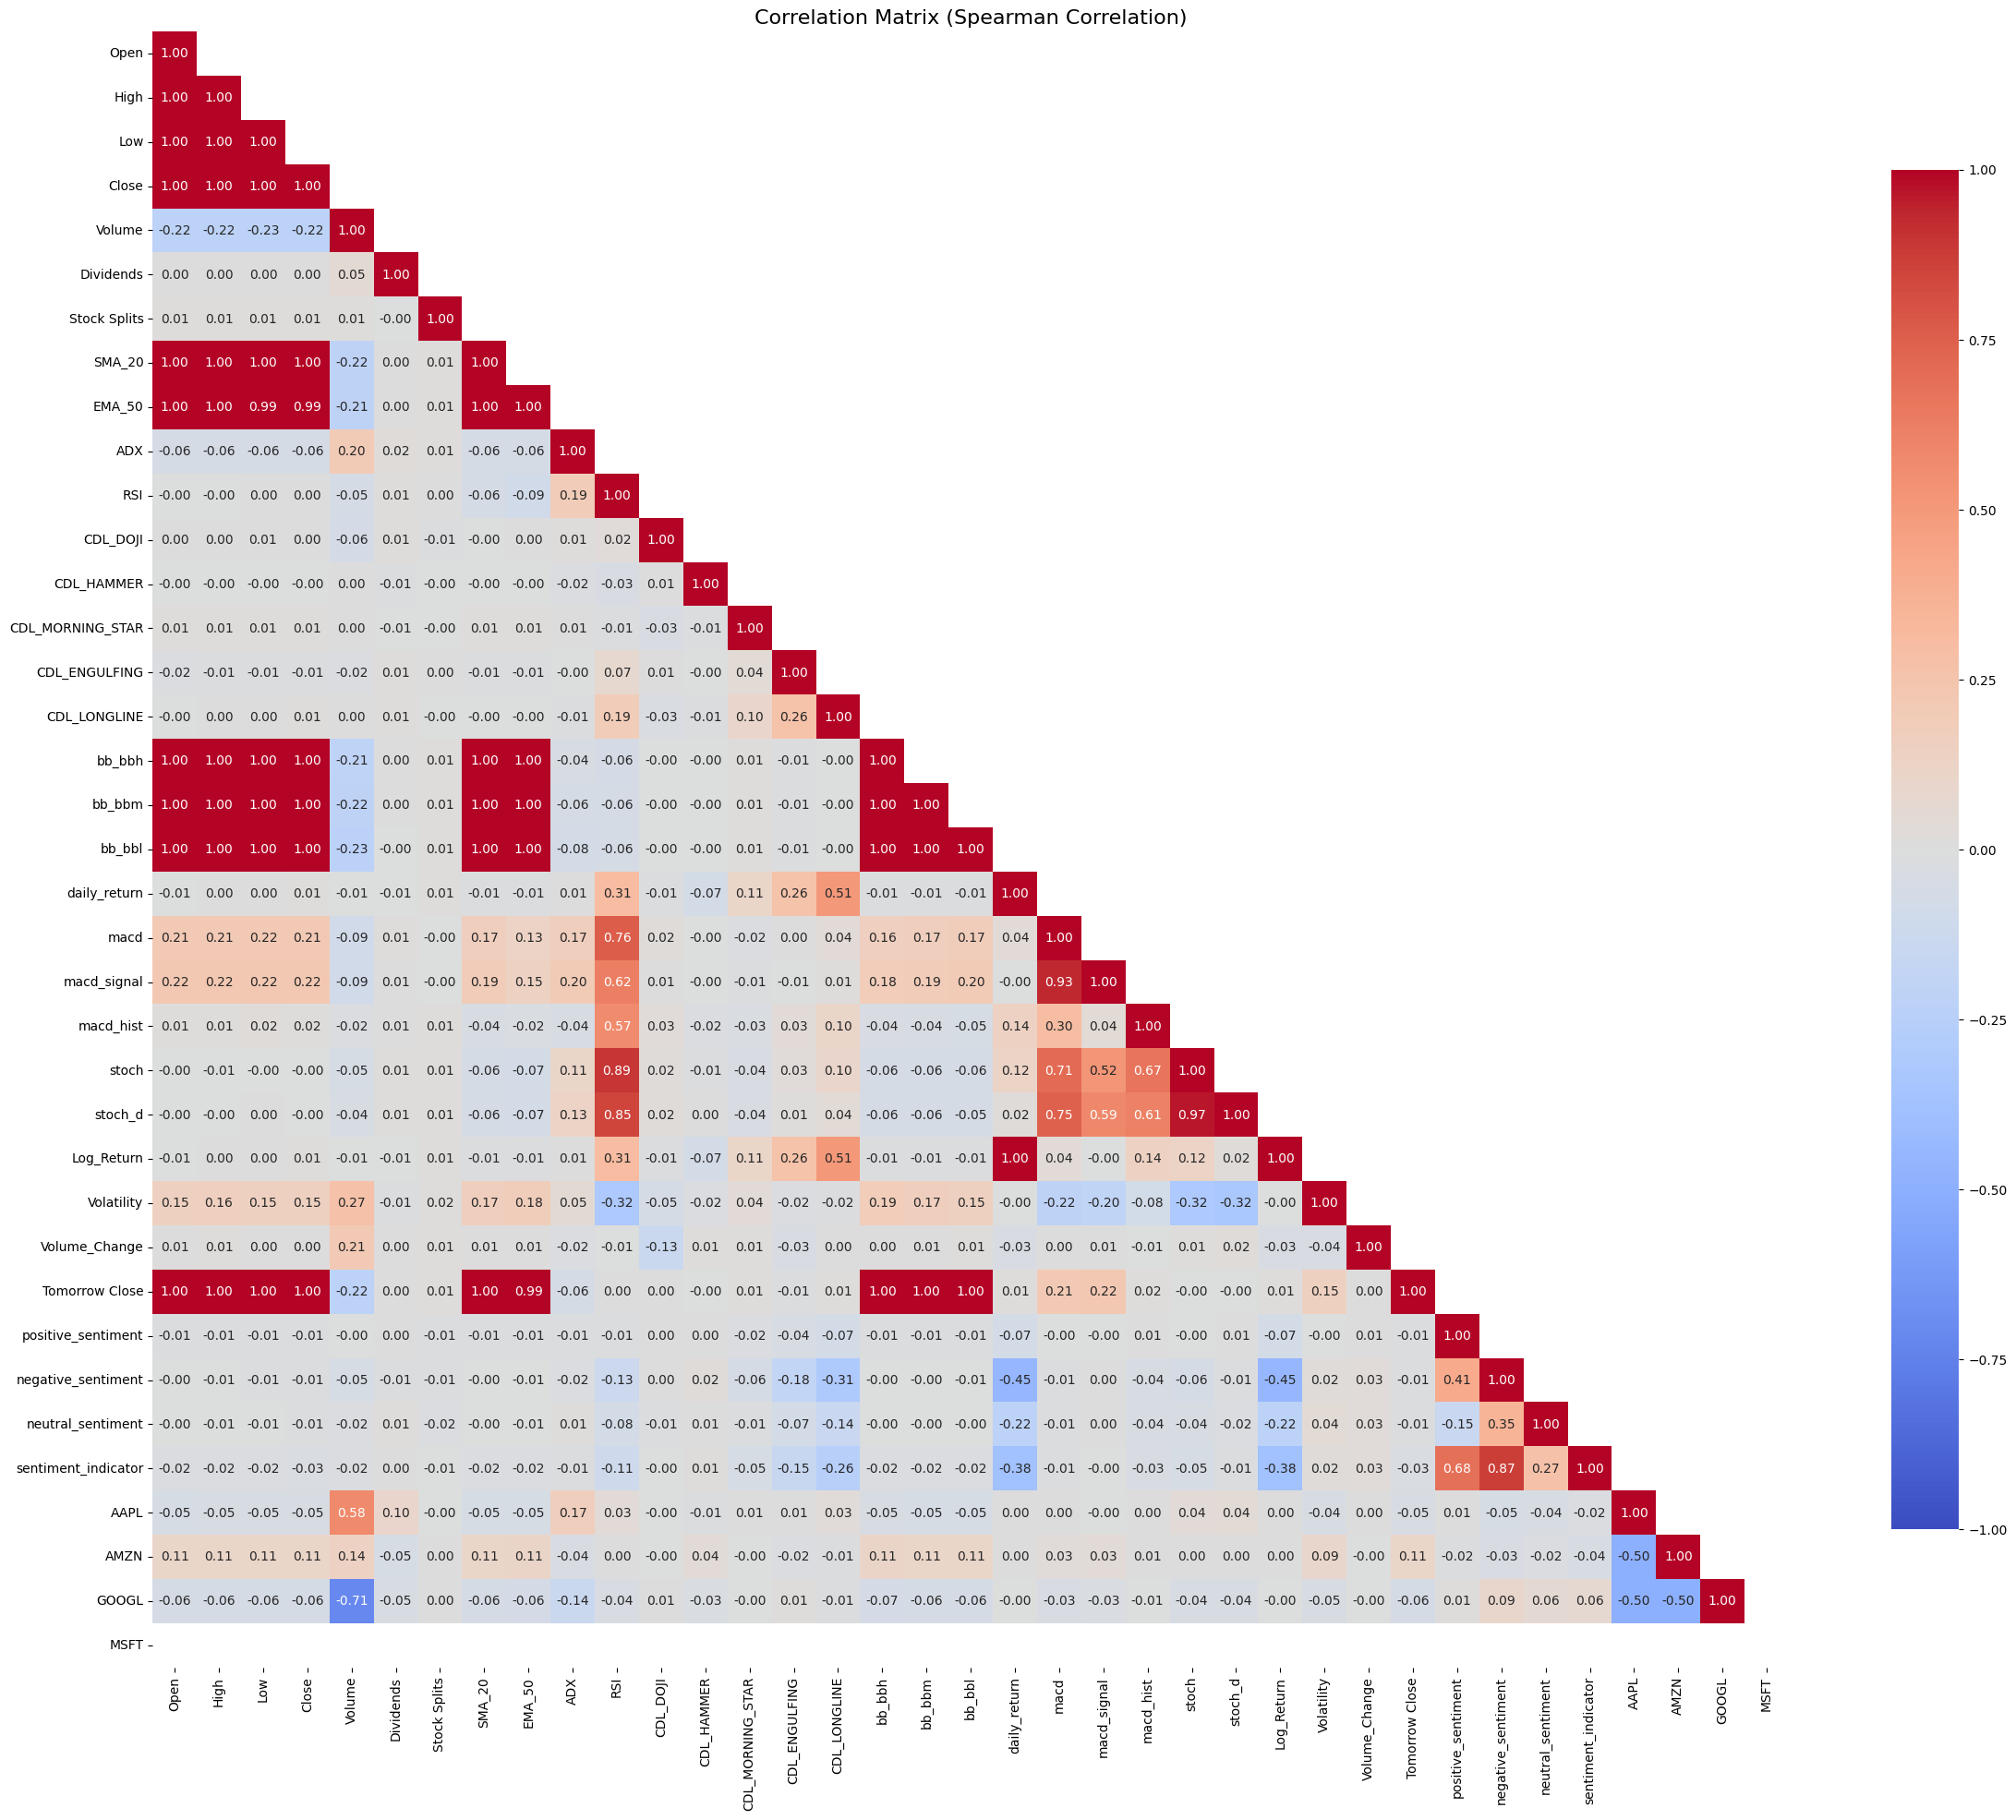

In [25]:
def visualize_correlation_matrix(df, method='spearman', figsize=(24, 20), annot_fontsize=10, rotate_xlabels=90):
    """
    Generate a correlation matrix for numeric columns in the combined DataFrame with improved visibility.
    
    Parameters:
    final_df (pandas.DataFrame): The combined DataFrame
    method (str): Correlation method ('pearson', 'kendall', 'spearman')
    plot (bool): Whether to plot the correlation matrix heatmap
    figsize (tuple): Figure size for the plot
    annot_fontsize (int): Font size for annotation numbers
    rotate_xlabels (int): Degree of rotation for x-axis labels
    
    Returns:
    pandas.DataFrame: Correlation matrix
    """
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr(method=method)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                vmin=-1, vmax=1, center=0, square=True, 
                cbar_kws={"shrink": .8}, annot_kws={"size": annot_fontsize},
                ax=ax)
    
    ax.set_title(f'Correlation Matrix ({method.capitalize()} Correlation)', fontsize=16)
    plt.xticks(rotation=rotate_xlabels)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

corr_matrix = visualize_correlation_matrix(df_train)
corr_matrix

In [26]:
# Vemos las que tienen una correlación superior a 0.8 para tratarlas

def list_high_correlations(final_df, threshold=0.8, method='spearman'):
    """
    Extract and list correlations above a specified threshold.
    
    Parameters:
    final_df (pandas.DataFrame): The combined DataFrame
    threshold (float): Correlation threshold (default 0.8)
    method (str): Correlation method ('pearson', 'kendall', 'spearman')
    
    Returns:
    list: List of tuples containing high correlations
    """
    # Select numeric columns
    numeric_df = final_df.select_dtypes(include=[np.number])
    
    # Compute correlation matrix
    corr_matrix = numeric_df.corr(method=method)
    
    # Extract high correlations
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr.append((corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    # Sort by absolute correlation value
    high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
    
    return high_corr

high_correlations = list_high_correlations(df_train, threshold=0.8)
high_correlations

[('bb_bbm', 'SMA_20', 1.0),
 ('Log_Return', 'daily_return', 1.0),
 ('High', 'Open', 0.9998652918357546),
 ('Close', 'Low', 0.9998537133147067),
 ('Close', 'High', 0.9998404092041083),
 ('Low', 'Open', 0.9998313196062191),
 ('Low', 'High', 0.9998091438934107),
 ('Close', 'Open', 0.9996665095837391),
 ('Tomorrow Close', 'Close', 0.9994596824098726),
 ('Tomorrow Close', 'Low', 0.9993459893429827),
 ('Tomorrow Close', 'High', 0.9993144702759755),
 ('Tomorrow Close', 'Open', 0.9991385274510189),
 ('bb_bbh', 'SMA_20', 0.9988828262856863),
 ('bb_bbm', 'bb_bbh', 0.9988828262856863),
 ('bb_bbl', 'SMA_20', 0.9985035417814682),
 ('bb_bbl', 'bb_bbm', 0.9985035417814682),
 ('EMA_50', 'SMA_20', 0.9984737533447556),
 ('bb_bbm', 'EMA_50', 0.9984737533447556),
 ('bb_bbh', 'EMA_50', 0.9980461495924626),
 ('SMA_20', 'High', 0.9973981924351967),
 ('bb_bbm', 'High', 0.9973981924351967),
 ('SMA_20', 'Open', 0.9973195956622205),
 ('bb_bbm', 'Open', 0.9973195956622205),
 ('SMA_20', 'Close', 0.9970982987820489

In [27]:
# Empezamos quitando algunas columnas no necesarias como:
# - Los sentimientos de noticias se recogen en un único indicador de sentimiento
# - Los dividentos y Stock Splits por ser ceros
# - Datos correlacionados como las medias de Close o ATR

columns_to_drop = ['positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 
                   'Dividends', 'Stock Splits','EMA_50', 'SMA_20'
                  ]

df_train = df_train.drop(columns_to_drop, axis=1)
df_train.tail()

,Open,High,Low,Close,Volume,ADX,RSI,CDL_DOJI,CDL_HAMMER,CDL_MORNING_STAR,...,stoch_d,Log_Return,Volatility,Volume_Change,Tomorrow Close,sentiment_indicator,AAPL,AMZN,GOOGL,MSFT
7543,156.092875,159.238694,155.773291,157.031631,18688700,31.258177,35.960448,0,0,0,...,25.565586,0.005037,0.018459,-0.034365,150.720001,-1,0,0,1,0
7544,157.091551,157.620848,150.350496,150.720001,37912100,32.822092,28.929215,0,0,0,...,14.545540,-0.041023,0.023888,1.028611,148.710007,0,0,0,1,0
7545,152.509995,153.399994,147.220001,148.710007,39260500,34.628018,27.111218,0,0,0,...,7.428526,-0.013426,0.020068,0.035566,148.660004,0,0,0,1,0
7546,150.449997,151.270004,148.339996,148.660004,31118800,36.304950,27.065649,0,0,0,...,5.671323,-0.000336,0.018064,-0.207376,151.160004,1,0,0,1,0
7547,149.919998,151.500000,147.520004,151.160004,29555100,37.955208,33.118330,0,0,0,...,7.494307,0.016677,0.022068,-0.050249,NaN,0,0,0,1,0


In [28]:
# Establecemos condiciones de compra y convierto los datos de patrones a 0 y 1 (solo compra)
columns_to_replace = ['CDL_DOJI', 'CDL_HAMMER', 'CDL_MORNING_STAR', 'CDL_ENGULFING', 'CDL_LONGLINE']
for column in columns_to_replace:
    df_train[column] = df_train[column].replace({100: 1, -100: 0})

def conditions_buy(df):
    conditions_low = [
        (df['CDL_ENGULFING'] == 100) & (df['Low'] < df['bb_bbl']) & (df['High'] < df['bb_bbm']),
        (df['CDL_LONGLINE'] == 100) & (df['Close'] > df['bb_bbm']) & (df['High'] < df['bb_bbh']),
        (df['CDL_DOJI'] == 100) & (df['Low'] < df['bb_bbl']) & (df['High'] < df['bb_bbm']),
        (df['CDL_HAMMER'] == 100) & (df['Low'] < df['bb_bbl']) & (df['High'] < df['bb_bbm']),
        (df['CDL_MORNING_STAR'] == 100) & (df['Low'] < df['bb_bbl'] ) & (df['High'] < df['bb_bbm']),
        (df['stoch_d'] > df['stoch']),
        (df['macd_signal'] > df['macd'])
    ]
    return conditions_low

conditions = conditions_buy(df_train)
choice_low = [1,1,1,1,1,1,1]
df_train['low_buy'] = np.select(conditions, choice_low, default=0)

In [29]:
# Eliminar columnas tras tratamiento y daily_return por haber calculado los logaritmos mejor

columns_to_drop = ['Open', 'High', 'Low', 
                   'stoch_d', 'stoch', 
                   'macd_signal', 'macd', 'macd_hist', 
                   'bb_bbm','bb_bbh', 'bb_bbl', 'daily_return'
                  ]

df_train = df_train.drop(columns_to_drop, axis=1)
df_train.tail()

,Close,Volume,ADX,RSI,CDL_DOJI,CDL_HAMMER,CDL_MORNING_STAR,CDL_ENGULFING,CDL_LONGLINE,Log_Return,Volatility,Volume_Change,Tomorrow Close,sentiment_indicator,AAPL,AMZN,GOOGL,MSFT,low_buy
7543,157.031631,18688700,31.258177,35.960448,0,0,0,1,0,0.005037,0.018459,-0.034365,150.720001,-1,0,0,1,0,1
7544,150.720001,37912100,32.822092,28.929215,0,0,0,0,0,-0.041023,0.023888,1.028611,148.710007,0,0,0,1,0,1
7545,148.710007,39260500,34.628018,27.111218,0,0,0,0,0,-0.013426,0.020068,0.035566,148.660004,0,0,0,1,0,1
7546,148.660004,31118800,36.304950,27.065649,0,0,0,0,0,-0.000336,0.018064,-0.207376,151.160004,1,0,0,1,0,1
7547,151.160004,29555100,37.955208,33.118330,0,0,0,0,0,0.016677,0.022068,-0.050249,NaN,0,0,0,1,0,1


In [30]:
# Trabajar los datos nulos
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7548 entries, 0 to 7547
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                7548 non-null   float64
 1   Volume               7548 non-null   int64  
 2   ADX                  7467 non-null   float64
 3   RSI                  7506 non-null   float64
 4   CDL_DOJI             7548 non-null   int64  
 5   CDL_HAMMER           7548 non-null   int64  
 6   CDL_MORNING_STAR     7548 non-null   int64  
 7   CDL_ENGULFING        7548 non-null   int64  
 8   CDL_LONGLINE         7548 non-null   int64  
 9   Log_Return           7545 non-null   float64
 10  Volatility           7533 non-null   float64
 11  Volume_Change        7545 non-null   float64
 12  Tomorrow Close       7545 non-null   float64
 13  sentiment_indicator  7548 non-null   int64  
 14  AAPL                 7548 non-null   int64  
 15  AMZN                 7548 non-null   i

In [31]:
# Podemos eliminar directamente los valores nulos porque los datos faltantes son los necesarios como ventana
# inicial de la serie temporal para calcular los indicadores técnicos y fundamentales usados.
# No tiene sentido hacer media al comienzo de la serie.

df_train = df_train.dropna()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7464 entries, 27 to 7546
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                7464 non-null   float64
 1   Volume               7464 non-null   int64  
 2   ADX                  7464 non-null   float64
 3   RSI                  7464 non-null   float64
 4   CDL_DOJI             7464 non-null   int64  
 5   CDL_HAMMER           7464 non-null   int64  
 6   CDL_MORNING_STAR     7464 non-null   int64  
 7   CDL_ENGULFING        7464 non-null   int64  
 8   CDL_LONGLINE         7464 non-null   int64  
 9   Log_Return           7464 non-null   float64
 10  Volatility           7464 non-null   float64
 11  Volume_Change        7464 non-null   float64
 12  Tomorrow Close       7464 non-null   float64
 13  sentiment_indicator  7464 non-null   int64  
 14  AAPL                 7464 non-null   int64  
 15  AMZN                 7464 non-null   int64

In [32]:
# Usar clustering para detectar diferentes regímenes de mercado en todas las acciones según la volatilidad: alcista, bajista y lateral

X_for_clustering = df_train[['Volatility']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_for_clustering)
df_train['Market_Regime'] = kmeans.predict(X_for_clustering)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


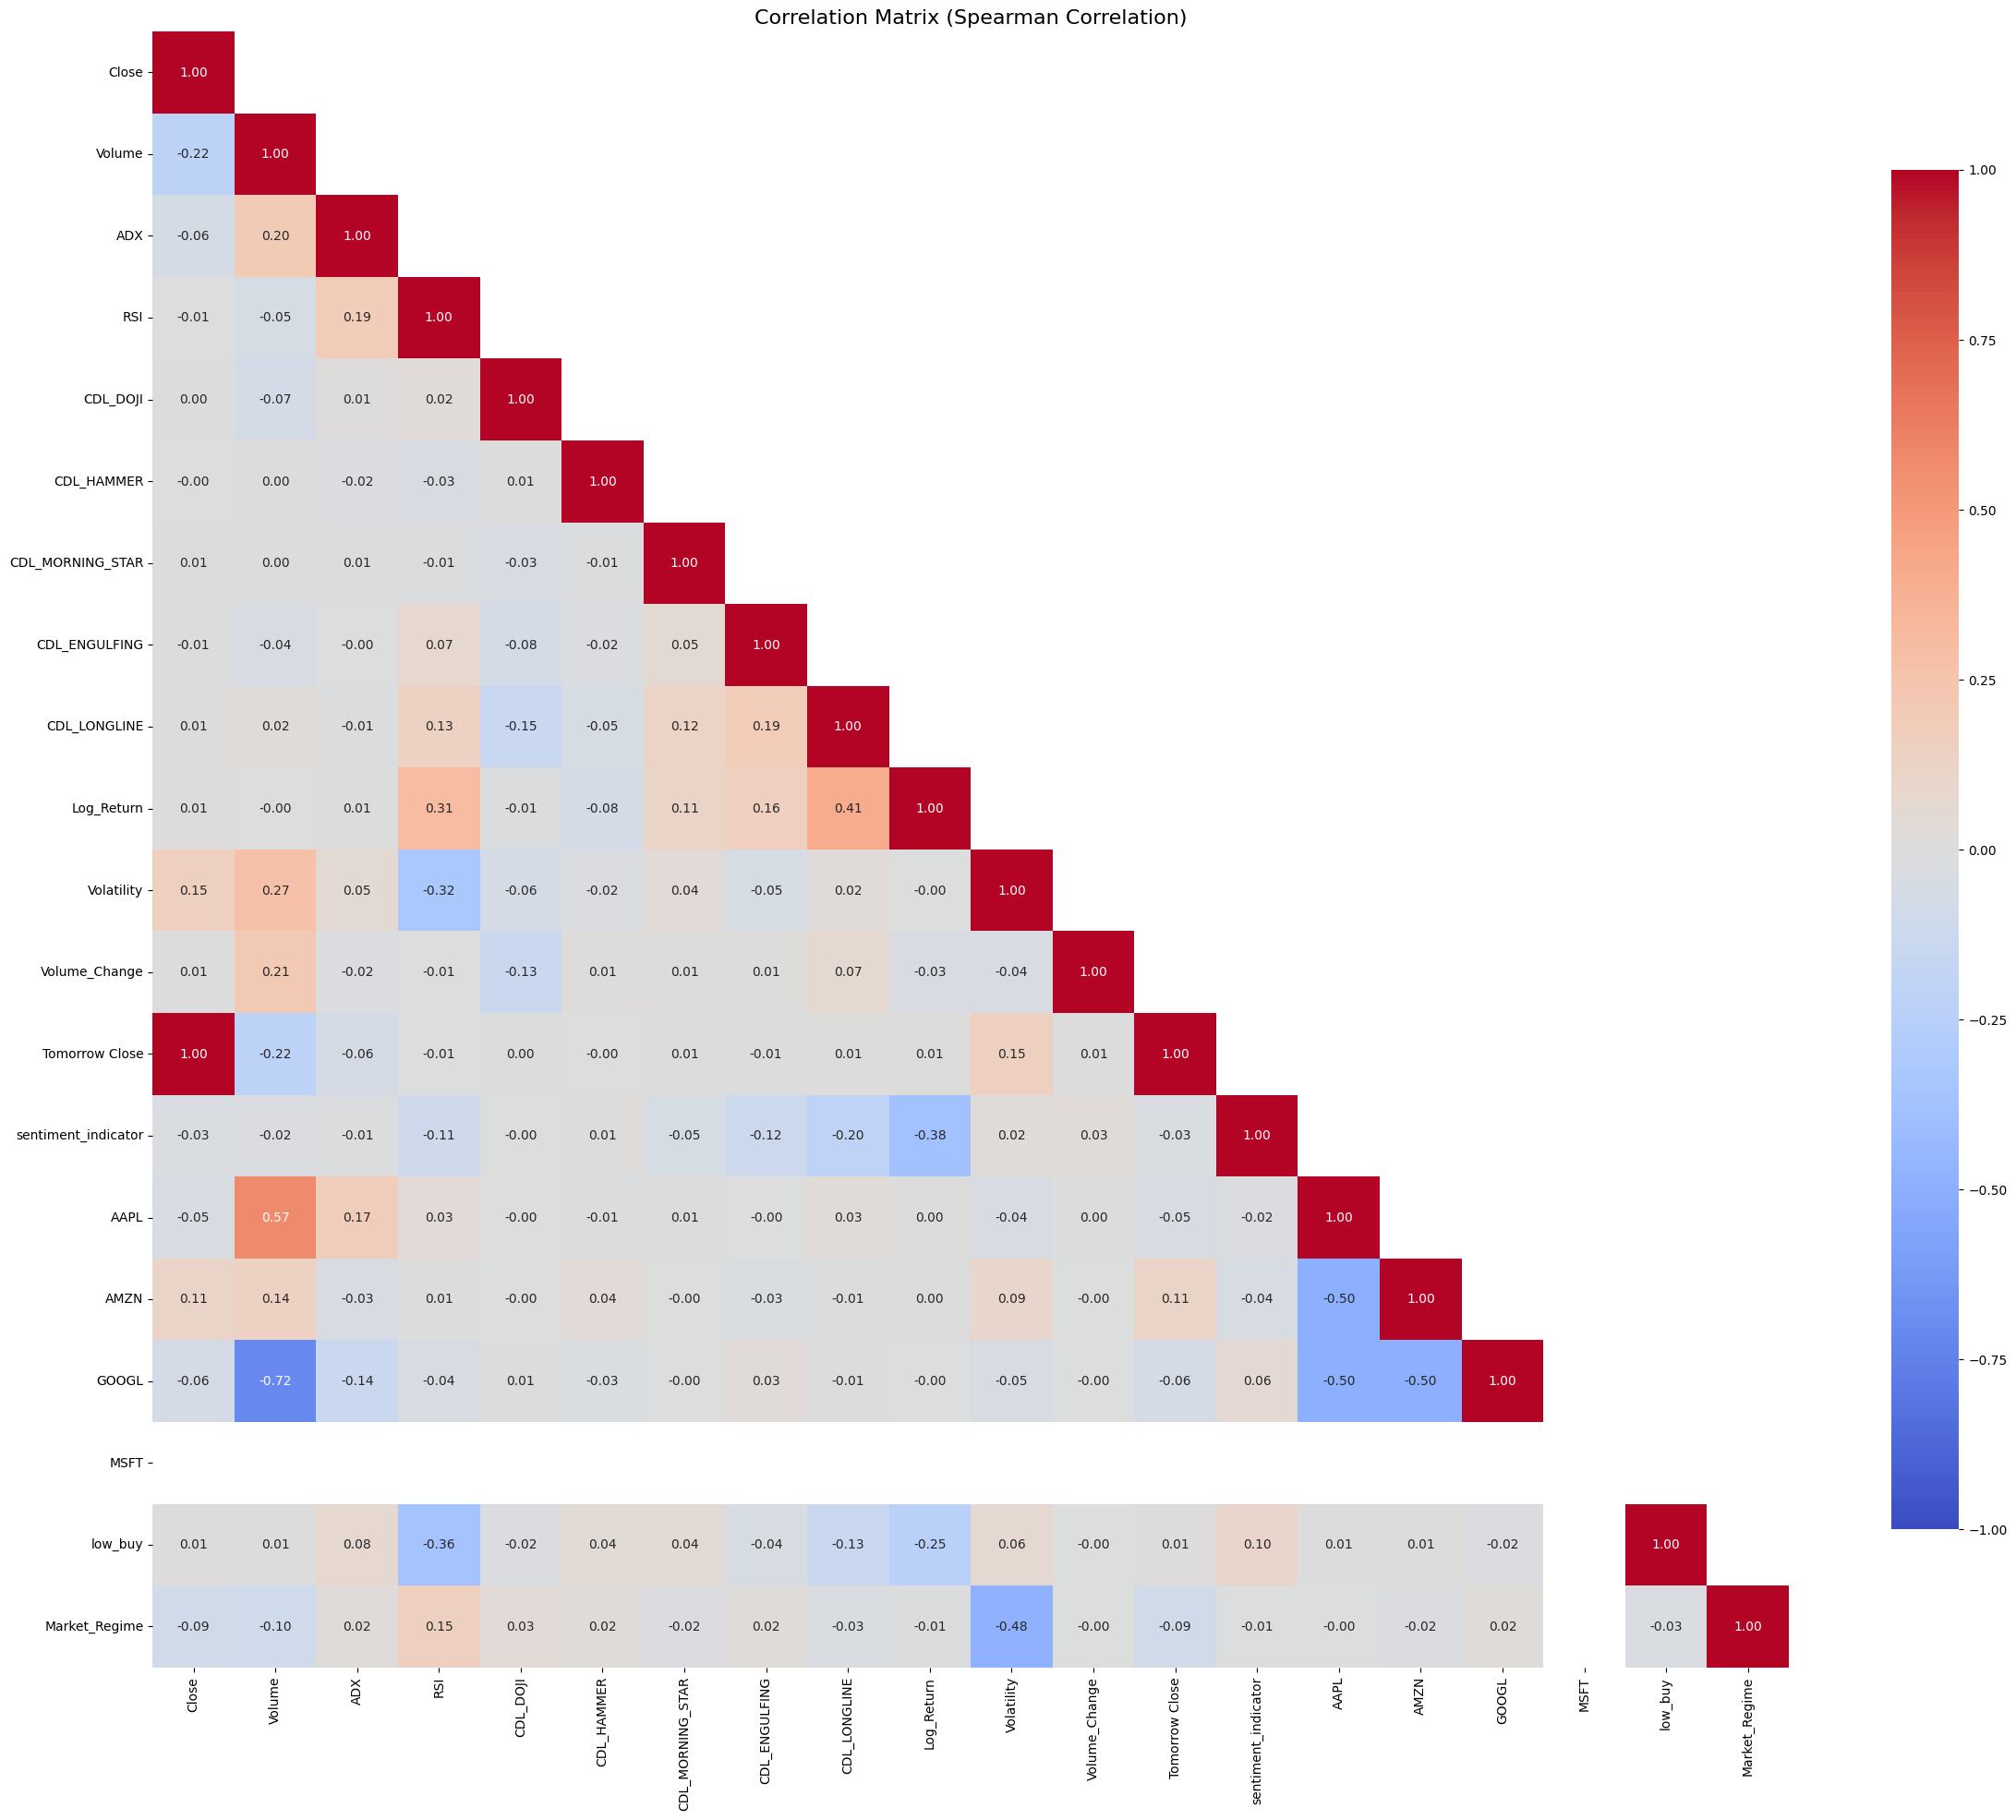

In [33]:
corr_matrix = visualize_correlation_matrix(df_train)
corr_matrix

In [34]:
# Reseteamos índice
df_train.reset_index(drop=True, inplace=True)

In [35]:
# Podemos ver los outliers como los retornos que están más allá de 3 desviaciones típicas
mean = df_train['Log_Return'].mean()
std_dev = df_train['Log_Return'].std()

outliers = df_train[(df_train['Log_Return'] > mean + 3 * std_dev) | (df_train['Log_Return'] < mean - 3 * std_dev)]
print(outliers)
# En una serie temporal como esta, no podemos perder la secuencialidad, por lo que mantenemos los valores

           Close     Volume        ADX        RSI  CDL_DOJI  CDL_HAMMER  \
210    23.877588  513102000  37.821058  26.687883         0           0   
318    21.181849  533478800  40.788616  33.584986         0           0   
381    22.299850  458408400  30.156009  26.605044         0           0   
444    23.612217  369379200  17.718850  67.227028         0           0   
574    29.842007  447940000  35.736167  86.272463         0           0   
...          ...        ...        ...        ...       ...         ...   
7061  107.473877   69883800  20.716267  71.864386         0           0   
7065   99.124557   94743500  22.990342  52.536063         0           0   
7244  125.299736   84366200  18.245209  34.040159         0           0   
7310  139.753952   71910000  31.047111  43.617323         0           0   
7370  171.525284   64665300  27.858455  73.698527         0           0   

      CDL_MORNING_STAR  CDL_ENGULFING  CDL_LONGLINE  Log_Return  Volatility  \
210                 

In [36]:
# Aplicamos lo mismo a test

In [37]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# Condiciones de compra
columns_to_replace = ['CDL_DOJI', 'CDL_HAMMER', 'CDL_MORNING_STAR', 'CDL_ENGULFING', 'CDL_LONGLINE']
for column in columns_to_replace:
    df_test[column] = df_test[column].replace({100: 1, -100: 0})
    
conditions = conditions_buy(df_test)
choice_low = [1,1,1,1,1,1,1]
df_test['low_buy'] = np.select(conditions, choice_low, default=0)
# Columnas a eliminar
columns_to_drop = ['positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 
                   'Dividends', 'Stock Splits','EMA_50', 'SMA_20',
                    'Open', 'High', 'Low', 
                   'stoch_d', 'stoch', 
                   'macd_signal', 'macd', 'macd_hist', 
                   'bb_bbm','bb_bbh', 'bb_bbl','daily_return'
                  ]
df_test = df_test.drop(columns_to_drop, axis=1)
# Valores nulos
df_test = df_test.dropna()
X_for_clustering = df_test[['Volatility']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_for_clustering)
df_test['Market_Regime'] = kmeans.predict(X_for_clustering)
df_test.reset_index(drop=True, inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2488 entries, 0 to 2487
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                2488 non-null   float64
 1   Volume               2488 non-null   int64  
 2   ADX                  2488 non-null   float64
 3   RSI                  2488 non-null   float64
 4   CDL_DOJI             2488 non-null   int64  
 5   CDL_HAMMER           2488 non-null   int64  
 6   CDL_MORNING_STAR     2488 non-null   int64  
 7   CDL_ENGULFING        2488 non-null   int64  
 8   CDL_LONGLINE         2488 non-null   int64  
 9   Log_Return           2488 non-null   float64
 10  Volatility           2488 non-null   float64
 11  Volume_Change        2488 non-null   float64
 12  Tomorrow Close       2488 non-null   float64
 13  sentiment_indicator  2488 non-null   int64  
 14  AAPL                 2488 non-null   int64  
 15  AMZN                 2488 non-null   i

In [38]:
df_test.reset_index(drop=True, inplace=True)


In [39]:
df_test.head()

,Close,Volume,ADX,RSI,CDL_DOJI,CDL_HAMMER,CDL_MORNING_STAR,CDL_ENGULFING,CDL_LONGLINE,Log_Return,Volatility,Volume_Change,Tomorrow Close,sentiment_indicator,AAPL,AMZN,GOOGL,MSFT,low_buy,Market_Regime
0,38.373245,36433800,28.469793,47.392935,0,0,0,0,0,0.017986,0.015662,0.055199,37.945736,1,0,0,0,1,0,0
1,37.945736,33570900,27.074979,44.372322,0,0,0,0,0,-0.011203,0.015520,-0.078578,38.492966,0,0,0,0,1,0,0
2,38.492966,45451900,25.267369,48.865031,0,0,0,0,0,0.014318,0.012687,0.353908,39.442017,-1,0,0,0,1,0,2
3,39.442017,61076700,24.884276,55.567335,0,0,0,0,0,0.024356,0.013524,0.343766,39.253910,-1,0,0,0,1,0,2
4,39.253910,30371300,24.528546,54.055023,0,0,0,0,0,-0.004781,0.015323,-0.502735,39.749840,1,0,0,0,1,0,0


In [40]:
df_close = df_test['Close']

### Preparamos los datos para el Modelado

In [41]:

X_train, y_train = df_train.drop(['Tomorrow Close','Log_Return','Close'], axis=1), df_train['Log_Return']
X_test_msft, y_test_msft = df_test.drop(['Tomorrow Close','Log_Return','Close'], axis=1), df_test['Log_Return']

# Escalado por cada acción
scaler_X_aapl = MinMaxScaler()
scaler_X_amzn = MinMaxScaler()
scaler_X_googl = MinMaxScaler()

scaler_y_aapl = MinMaxScaler()
scaler_y_amzn = MinMaxScaler()
scaler_y_googl = MinMaxScaler()

# Escalado de los datos
X_train_scaled_aapl = scaler_X_aapl.fit_transform(X_train[df_train['AAPL'] == 1])
y_train_scaled_aapl = scaler_y_aapl.fit_transform(y_train[df_train['AAPL'] == 1].values.reshape(-1, 1))

X_train_scaled_amzn = scaler_X_amzn.fit_transform(X_train[df_train['AMZN'] == 1])
y_train_scaled_amzn = scaler_y_amzn.fit_transform(y_train[df_train['AMZN'] == 1].values.reshape(-1, 1))

X_train_scaled_googl = scaler_X_googl.fit_transform(X_train[df_train['GOOGL'] == 1])
y_train_scaled_googl = scaler_y_googl.fit_transform(y_train[df_train['GOOGL'] == 1].values.reshape(-1, 1))

# Escalado MSFT

# Dividimos MSFT en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
train_size = int(0.5 * len(X_test_msft))  # Ajustar el tamaño según prefieras
X_train_msft = X_test_msft[:train_size]
X_test_msft_final = X_test_msft[train_size:]

# Similarmente para y_test_msft
y_train_msft = y_test_msft[:train_size]
y_test_msft_final = y_test_msft[train_size:]

# Escalar los datos de entrenamiento de MSFT
scaler_X_msft = MinMaxScaler()
X_train_scaled_msft = scaler_X_msft.fit_transform(X_train_msft)

# También para la variable objetivo (y)
scaler_y_msft = MinMaxScaler()
y_train_scaled_msft = scaler_y_msft.fit_transform(y_train_msft.values.reshape(-1, 1))

# Escalar el conjunto de prueba de MSFT usando el mismo escalador ajustado con train_msft
X_test_scaled_msft = scaler_X_msft.transform(X_test_msft_final)

# También para la variable objetivo (y_test_msft)
y_test_scaled_msft = scaler_y_msft.transform(y_test_msft_final.values.reshape(-1, 1))

print(X_train_scaled_aapl.shape)
print(y_train_scaled_aapl.shape)

print(X_train_scaled_amzn.shape)
print(y_train_scaled_amzn.shape)

print(X_train_scaled_googl.shape)
print(y_train_scaled_googl.shape)

print(X_train_scaled_msft.shape)

print(X_test_scaled_msft.shape)
print(y_test_scaled_msft.shape)




(2488, 17)
(2488, 1)
(2488, 17)
(2488, 1)
(2488, 17)
(2488, 1)
(1244, 17)
(1244, 17)
(1244, 1)


In [42]:
# Métricas financieras
def sharpe_ratio(returns, risk_free_rate=0.0):
    """Calcula el ratio de Sharpe."""
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

def max_drawdown(returns):
    """Calcula el Max Drawdown."""
    cumulative = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = peak - cumulative
    return np.max(drawdown)

# Walk-Forward Validation para cada acción
def walk_forward_validation(X, y, initial_train_size, step_size):
    splits = []
    for i in range(initial_train_size, len(X), step_size):
        X_train_split = X[:i]
        X_test_split = X[i:i + step_size]
        y_train_split = y[:i]
        y_test_split = y[i:i + step_size]
        splits.append((X_train_split, X_test_split, y_train_split, y_test_split))
    return splits

# Aplicar Walk-Forward Validation a cada acción
X_train_aapl_splits = walk_forward_validation(X_train_scaled_aapl, y_train_scaled_aapl, initial_train_size=60, step_size=30)
X_train_amzn_splits = walk_forward_validation(X_train_scaled_amzn, y_train_scaled_amzn, initial_train_size=60, step_size=30)
X_train_googl_splits = walk_forward_validation(X_train_scaled_googl, y_train_scaled_googl, initial_train_size=60, step_size=30)

# Combinar los splits de AAPL, AMZN y GOOGL
train_splits_combined = []
for i in range(len(X_train_aapl_splits)):  # Iterar sobre cada split
    X_train_combined = np.concatenate([X_train_aapl_splits[i][0], X_train_amzn_splits[i][0], X_train_googl_splits[i][0]])
    X_test_combined = np.concatenate([X_train_aapl_splits[i][1], X_train_amzn_splits[i][1], X_train_googl_splits[i][1]])
    y_train_combined = np.concatenate([X_train_aapl_splits[i][2], X_train_amzn_splits[i][2], X_train_googl_splits[i][2]])
    y_test_combined = np.concatenate([X_train_aapl_splits[i][3], X_train_amzn_splits[i][3], X_train_googl_splits[i][3]])
    train_splits_combined.append((X_train_combined, X_test_combined, y_train_combined, y_test_combined))


# Asegurarnos de que las dimensiones de entrada sean (samples, 1, features)
X_train_combined_reshaped = X_train_combined.reshape(X_train_combined.shape[0], 1, X_train_combined.shape[1])
X_test_combined_reshaped = X_test_combined.reshape(X_test_combined.shape[0], 1, X_test_combined.shape[1])
print(f"Forma de X_train_combined después de reshape: {X_train_combined_reshaped.shape}")
print(f"Forma de y_train_combined después de reshape: {y_train_combined.shape}")
print(f"Forma de X_test_combined después de reshape: {X_test_combined_reshaped.shape}")
print(f"Forma de y_test_combined después de reshape: {y_test_combined.shape}")


Forma de X_train_combined después de reshape: (7380, 1, 17)
Forma de y_train_combined después de reshape: (7380, 1)
Forma de X_test_combined después de reshape: (84, 1, 17)
Forma de y_test_combined después de reshape: (84, 1)


## Modelo LSTM

In [43]:
# LSTM sin optimizacion de parametros

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# Definir el modelo LSTM
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, X_train_combined.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Entrenar y evaluar el modelo LSTM
mse_results = []
r2_results = []
sharpe_ratios = []
drawdowns = []

for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
    # Parte 1: LSTM para capturar tendencias
    X_train_combined_reshaped = X_train_combined.reshape(X_train_combined.shape[0], 1, X_train_combined.shape[1])
    X_test_combined_reshaped = X_test_combined.reshape(X_test_combined.shape[0], 1, X_test_combined.shape[1])

    model_lstm = build_lstm_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_lstm.fit(X_train_combined_reshaped, y_train_combined, epochs=20, batch_size=32, verbose=0, validation_data=(X_test_combined_reshaped, y_test_combined), callbacks=[early_stopping])

    # Hacer la predicción con LSTM para todo el conjunto de prueba
    y_pred_test = model_lstm.predict(X_test_combined_reshaped).flatten()

    # Calcular métricas
    mse_split = mean_squared_error(y_test_combined, y_pred_test)
    r2_split = r2_score(y_test_combined, y_pred_test)

    # Calcular los retornos correctamente
    predicted_returns = (y_pred_test[1:] - y_pred_test[:-1]) / y_pred_test[:-1]
    actual_returns = (y_test_combined[1:] - y_test_combined[:-1]) / y_test_combined[:-1]

    # Calcular Sharpe Ratio y Max Drawdown
    sharpe = sharpe_ratio(predicted_returns)
    drawdown = max_drawdown(predicted_returns)

    mse_results.append(mse_split)
    r2_results.append(r2_split)
    sharpe_ratios.append(sharpe)
    drawdowns.append(drawdown)

# Mostrar resultados del entrenamiento
print(f"MSE promedio en entrenamiento (LSTM): {np.mean(mse_results)}")
print(f"R² promedio en entrenamiento (LSTM): {np.mean(r2_results)}")
print(f"Ratio de Sharpe promedio (LSTM): {np.mean(sharpe_ratios)}")
print(f"Max Drawdown promedio (LSTM): {np.mean(drawdowns)}")

# Evaluar el modelo en MSFT
y_pred_test_msft = model_lstm.predict(X_test_scaled_msft.reshape(X_test_scaled_msft.shape[0], 1, X_test_scaled_msft.shape[1])).flatten()

# Desescalar las predicciones y los valores reales de MSFT
y_pred_test_msft = scaler_y_msft.inverse_transform(y_pred_test_msft.reshape(-1, 1))
y_test_msft = scaler_y_msft.inverse_transform(y_test_scaled_msft)

# Calcular las métricas de rendimiento en MSFT
mse_test_msft = mean_squared_error(y_test_msft, y_pred_test_msft)
r2_test_msft = r2_score(y_test_msft, y_pred_test_msft)

print(f"MSE en MSFT (LSTM): {mse_test_msft}")
print(f"R² en MSFT (LSTM): {r2_test_msft}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fd12f77b790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━

In [44]:
# random forest con escalado de acciones, walk forward para cada accion sin optimizacion de hiperparametros

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score


# Hiperparámetros fijos para Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,          # 200 árboles
    max_depth=15,              # Profundidad máxima de los árboles
    min_samples_split=5,       # Mínimo de muestras para dividir un nodo
    min_samples_leaf=2,        # Mínimo de muestras por hoja
    bootstrap=True,            # Usar bootstrap
    random_state=42            # Fijar semilla para reproducibilidad
)

mse_results = []
r2_results = []
sharpe_ratios = []
drawdowns = []
sharpe_actual_ratio = []


# Entrenar el modelo en los splits combinados
for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
    # Entrenar el modelo dentro del split
    rf_model.fit(X_train_combined, y_train_combined.ravel())
    
    # Predecir en el conjunto de prueba
    y_pred_split = rf_model.predict(X_test_combined)
    
    # Aplanar las predicciones y los valores verdaderos
    y_pred_split = y_pred_split.flatten()
    y_test_combined = y_test_combined.flatten()
    
    # Calcular métricas para cada split
    mse_split = mean_squared_error(y_test_combined, y_pred_split)
    r2_split = r2_score(y_test_combined, y_pred_split)
    
    # Calcular los retornos correctamente (cambio porcentual entre días consecutivos)
    predicted_returns = (y_pred_split[1:] - y_pred_split[:-1]) / y_pred_split[:-1]
    actual_returns = (y_test_combined[1:] - y_test_combined[:-1]) / y_test_combined[:-1]
    
    # Ahora usar los retornos calculados correctamente para el Sharpe Ratio y el Max Drawdown
    sharpe = sharpe_ratio(predicted_returns)
    drawdown = max_drawdown(predicted_returns)
    
    # Opcionalmente, puedes comparar el Sharpe Ratio basado en los retornos reales
    sharpe_actual = sharpe_ratio(actual_returns)
    
    # Guardar las métricas para cada split
    mse_results.append(mse_split)
    r2_results.append(r2_split)
    sharpe_ratios.append(sharpe)
    drawdowns.append(drawdown)
    sharpe_actual_ratio.append(sharpe_actual)


# Mostrar resultados del entrenamiento
print(f"MSE promedio en entrenamiento: {np.mean(mse_results)}")
print(f"R² promedio en entrenamiento: {np.mean(r2_results)}")
print(f"Ratio de Sharpe promedio: {np.mean(sharpe_ratios)}")
print(f"Ratio de Sharpe actual promedio: {np.nanmean(sharpe_actual_ratio)}")
print(f"Max Drawdown promedio: {np.mean(drawdowns)}")

# Evaluar el modelo en el conjunto de prueba de MSFT
y_pred_test_msft = rf_model.predict(X_test_scaled_msft)

# Desescalar las predicciones y los valores reales de MSFT
y_pred_test_msft = scaler_y_msft.inverse_transform(y_pred_test_msft.reshape(-1, 1))
y_test_msft = scaler_y_msft.inverse_transform(y_test_scaled_msft)

# Calcular las métricas de rendimiento en MSFT
mse_test_msft = mean_squared_error(y_test_msft, y_pred_test_msft)
r2_test_msft = r2_score(y_test_msft, y_pred_test_msft)

print(f"MSE en MSFT: {mse_test_msft}")
print(f"R² en MSFT: {r2_test_msft}")


MSE promedio en entrenamiento: 0.004448541565538956
R² promedio en entrenamiento: 0.32801671292444495
Ratio de Sharpe promedio: 0.05147412102693738
Ratio de Sharpe actual promedio: 0.07548330341773643
Max Drawdown promedio: 0.37032081414618656
MSE en MSFT: 0.0002104915165179775
R² en MSFT: 0.42647307633979525


In [45]:
# gru con escalado y walk forward sin optimizacion de parametros
from keras.layers import GRU, Dense, Dropout

# Definir el modelo GRU
def build_gru_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(1, X_train_combined.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Entrenar y evaluar el modelo GRU
mse_results_gru = []
r2_results_gru = []
sharpe_ratios_gru = []
drawdowns_gru = []

for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
    X_train_combined_reshaped = X_train_combined.reshape(X_train_combined.shape[0], 1, X_train_combined.shape[1])
    X_test_combined_reshaped = X_test_combined.reshape(X_test_combined.shape[0], 1, X_test_combined.shape[1])

    model_gru = build_gru_model()
    model_gru.fit(X_train_combined_reshaped, y_train_combined, epochs=20, batch_size=32, verbose=0)
    
    # Predecir y calcular métricas
    y_pred_split = model_gru.predict(X_test_combined_reshaped)
    
    mse_split = mean_squared_error(y_test_combined, y_pred_split)
    r2_split = r2_score(y_test_combined, y_pred_split)

    # Calcular los retornos correctamente
    predicted_returns = (y_pred_split[1:] - y_pred_split[:-1]) / y_pred_split[:-1]
    actual_returns = (y_test_combined[1:] - y_test_combined[:-1]) / y_test_combined[:-1]
    
    # Calcular Sharpe Ratio y Max Drawdown
    sharpe = sharpe_ratio(predicted_returns)
    drawdown = max_drawdown(predicted_returns)
    
    mse_results_gru.append(mse_split)
    r2_results_gru.append(r2_split)
    sharpe_ratios_gru.append(sharpe)
    drawdowns_gru.append(drawdown)

# Mostrar resultados del entrenamiento
print(f"MSE promedio en entrenamiento (GRU): {np.mean(mse_results_gru)}")
print(f"R² promedio en entrenamiento (GRU): {np.mean(r2_results_gru)}")
print(f"Ratio de Sharpe promedio (GRU): {np.mean(sharpe_ratios_gru)}")
print(f"Max Drawdown promedio (GRU): {np.mean(drawdowns_gru)}")

# Evaluar el modelo en MSFT
y_pred_test_msft_gru = model_gru.predict(X_test_scaled_msft.reshape(X_test_scaled_msft.shape[0], 1, X_test_scaled_msft.shape[1]))

# Desescalar las predicciones y los valores reales de MSFT
y_pred_test_msft_gru = scaler_y_msft.inverse_transform(y_pred_test_msft_gru)
y_test_msft = scaler_y_msft.inverse_transform(y_test_scaled_msft)

# Calcular las métricas de rendimiento en MSFT
mse_test_msft_gru = mean_squared_error(y_test_msft, y_pred_test_msft_gru)
r2_test_msft_gru = r2_score(y_test_msft, y_pred_test_msft_gru)

print(f"MSE en MSFT (GRU): {mse_test_msft_gru}")
print(f"R² en MSFT (GRU): {r2_test_msft_gru}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 

In [46]:
# lstm + rf
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

# Definir el modelo LSTM
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, X_train_combined.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Entrenar y evaluar el modelo híbrido LSTM + Random Forest
mse_results_hybrid = []
r2_results_hybrid = []
sharpe_ratios_hybrid = []
drawdowns_hybrid = []

for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
    # Parte 1: LSTM para capturar tendencias
    X_train_combined_reshaped = X_train_combined.reshape(X_train_combined.shape[0], 1, X_train_combined.shape[1])
    X_test_combined_reshaped = X_test_combined.reshape(X_test_combined.shape[0], 1, X_test_combined.shape[1])

    model_lstm = build_lstm_model()
    model_lstm.fit(X_train_combined_reshaped, y_train_combined, epochs=20, batch_size=32, verbose=0)

    # Predicciones de LSTM en el conjunto de prueba
    y_pred_lstm_train = model_lstm.predict(X_train_combined_reshaped).flatten()  # Aplanar las predicciones de LSTM

    # Calcular residuos (errores) de LSTM para el conjunto de entrenamiento
    residuals_train = y_train_combined.flatten() - y_pred_lstm_train

    # Parte 2: Random Forest para ajustar los residuos
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train_combined, residuals_train)

    # Predicciones de Random Forest en el conjunto de prueba (en el espacio de los residuos)
    y_pred_rf_test = rf_model.predict(X_test_combined)

    # Predicciones de LSTM en el conjunto de prueba
    y_pred_lstm_test = model_lstm.predict(X_test_combined_reshaped).flatten()  # Aplanar para que las dimensiones coincidan

    # Combinación de predicciones de LSTM + Random Forest
    y_pred_hybrid_test = y_pred_lstm_test + y_pred_rf_test  # Ambas predicciones ahora deberían tener la misma forma

    # Calcular métricas
    mse_split = mean_squared_error(y_test_combined, y_pred_hybrid_test)
    r2_split = r2_score(y_test_combined, y_pred_hybrid_test)

    # Calcular los retornos correctamente
    predicted_returns = (y_pred_hybrid_test[1:] - y_pred_hybrid_test[:-1]) / y_pred_hybrid_test[:-1]
    actual_returns = (y_test_combined[1:] - y_test_combined[:-1]) / y_test_combined[:-1]

    # Calcular Sharpe Ratio y Max Drawdown
    sharpe = sharpe_ratio(predicted_returns)
    drawdown = max_drawdown(predicted_returns)

    mse_results_hybrid.append(mse_split)
    r2_results_hybrid.append(r2_split)
    sharpe_ratios_hybrid.append(sharpe)
    drawdowns_hybrid.append(drawdown)

# Mostrar resultados del entrenamiento
print(f"MSE promedio en entrenamiento (Híbrido LSTM + Random Forest): {np.mean(mse_results_hybrid)}")
print(f"R² promedio en entrenamiento (Híbrido LSTM + Random Forest): {np.mean(r2_results_hybrid)}")
print(f"Ratio de Sharpe promedio (Híbrido LSTM + Random Forest): {np.mean(sharpe_ratios_hybrid)}")
print(f"Max Drawdown promedio (Híbrido LSTM + Random Forest): {np.mean(drawdowns_hybrid)}")

# Evaluar el modelo en MSFT
y_pred_test_msft_hybrid = model_lstm.predict(X_test_scaled_msft.reshape(X_test_scaled_msft.shape[0], 1, X_test_scaled_msft.shape[1])).flatten() + rf_model.predict(X_test_scaled_msft)

# Desescalar las predicciones y los valores reales de MSFT
y_pred_test_msft_hybrid = scaler_y_msft.inverse_transform(y_pred_test_msft_hybrid.reshape(-1, 1))
y_test_msft = scaler_y_msft.inverse_transform(y_test_scaled_msft)

# Calcular las métricas de rendimiento en MSFT
mse_test_msft_hybrid = mean_squared_error(y_test_msft, y_pred_test_msft_hybrid)
r2_test_msft_hybrid = r2_score(y_test_msft, y_pred_test_msft_hybrid)

print(f"MSE en MSFT (Híbrido LSTM + Random Forest): {mse_test_msft_hybrid}")
print(f"R² en MSFT (Híbrido LSTM + Random Forest): {r2_test_msft_hybrid}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [47]:
# gru + rf
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

# Definir el modelo GRU
def build_gru_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(1, X_train_combined.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Entrenar y evaluar el modelo híbrido GRU + Random Forest
mse_results_hybrid = []
r2_results_hybrid = []
sharpe_ratios_hybrid = []
drawdowns_hybrid = []

for X_train_combined, X_test_combined, y_train_combined, y_test_combined in train_splits_combined:
    # Parte 1: GRU para capturar tendencias
    X_train_combined_reshaped = X_train_combined.reshape(X_train_combined.shape[0], 1, X_train_combined.shape[1])
    X_test_combined_reshaped = X_test_combined.reshape(X_test_combined.shape[0], 1, X_test_combined.shape[1])

    model_gru = build_gru_model()
    model_gru.fit(X_train_combined_reshaped, y_train_combined, epochs=20, batch_size=32, verbose=0)

    # Predicciones de GRU en el conjunto de prueba
    y_pred_gru_train = model_gru.predict(X_train_combined_reshaped).flatten()

    # Calcular residuos (errores) de GRU para el conjunto de entrenamiento
    residuals_train = y_train_combined.flatten() - y_pred_gru_train

    # Parte 2: Random Forest para ajustar los residuos
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train_combined, residuals_train)

    # Predicciones de Random Forest en el conjunto de prueba (en el espacio de los residuos)
    y_pred_rf_test = rf_model.predict(X_test_combined)

    # Predicciones de GRU en el conjunto de prueba
    y_pred_gru_test = model_gru.predict(X_test_combined_reshaped).flatten()

    # Combinación de predicciones de GRU + Random Forest
    y_pred_hybrid_test = y_pred_gru_test + y_pred_rf_test

    # Calcular métricas
    mse_split = mean_squared_error(y_test_combined, y_pred_hybrid_test)
    r2_split = r2_score(y_test_combined, y_pred_hybrid_test)

    # Calcular los retornos correctamente
    predicted_returns = (y_pred_hybrid_test[1:] - y_pred_hybrid_test[:-1]) / y_pred_hybrid_test[:-1]
    actual_returns = (y_test_combined[1:] - y_test_combined[:-1]) / y_test_combined[:-1]

    # Calcular Sharpe Ratio y Max Drawdown
    sharpe = sharpe_ratio(predicted_returns)
    drawdown = max_drawdown(predicted_returns)

    mse_results_hybrid.append(mse_split)
    r2_results_hybrid.append(r2_split)
    sharpe_ratios_hybrid.append(sharpe)
    drawdowns_hybrid.append(drawdown)

# Mostrar resultados del entrenamiento
print(f"MSE promedio en entrenamiento (Híbrido GRU + Random Forest): {np.mean(mse_results_hybrid)}")
print(f"R² promedio en entrenamiento (Híbrido GRU + Random Forest): {np.mean(r2_results_hybrid)}")
print(f"Ratio de Sharpe promedio (Híbrido GRU + Random Forest): {np.mean(sharpe_ratios_hybrid)}")
print(f"Max Drawdown promedio (Híbrido GRU + Random Forest): {np.mean(drawdowns_hybrid)}")

# Evaluar el modelo en MSFT
y_pred_test_msft_hybrid = model_gru.predict(X_test_scaled_msft.reshape(X_test_scaled_msft.shape[0], 1, X_test_scaled_msft.shape[1])).flatten() + rf_model.predict(X_test_scaled_msft)

# Desescalar las predicciones y los valores reales de MSFT
y_pred_test_msft_hybrid = scaler_y_msft.inverse_transform(y_pred_test_msft_hybrid.reshape(-1, 1))
y_test_msft = scaler_y_msft.inverse_transform(y_test_scaled_msft)

# Calcular las métricas de rendimiento en MSFT
mse_test_msft_hybrid = mean_squared_error(y_test_msft, y_pred_test_msft_hybrid)
r2_test_msft_hybrid = r2_score(y_test_msft, y_pred_test_msft_hybrid)

print(f"MSE en MSFT (Híbrido GRU + Random Forest): {mse_test_msft_hybrid}")
print(f"R² en MSFT (Híbrido GRU + Random Forest): {r2_test_msft_hybrid}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

In [49]:
import joblib
# BACKTESTING

joblib.dump(model_lstm, 'lstm_model.pkl')

# Cargar el modelo guardado
best_lstm_model_loaded = joblib.load('lstm_model.pkl')

last_sequence = X_test_scaled_msft[-1].reshape(1, 1, X_test_scaled_msft.shape[1])  # Reorganiza la secuencia para el LSTM
log_return_pred_31 = best_lstm_model_loaded.predict(last_sequence).flatten()[0]  # Tomamos el valor predicho
df_test['Close'] = df_close.values

# Ajusta df_test para que tenga el mismo número de filas que las predicciones
df_test = df_test.tail(len(y_pred_test_msft))

# Ahora puedes agregar las predicciones al DataFrame ajustado
df_test['LSTM_Prediction'] = y_pred_test_msft




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


In [50]:
#df_test = df_test.drop(['LSTM_Prediction'],axis=1)

Precio de cierre del día 30 (real): 414.20
Precio de cierre del día 31 (predicho): 713.06


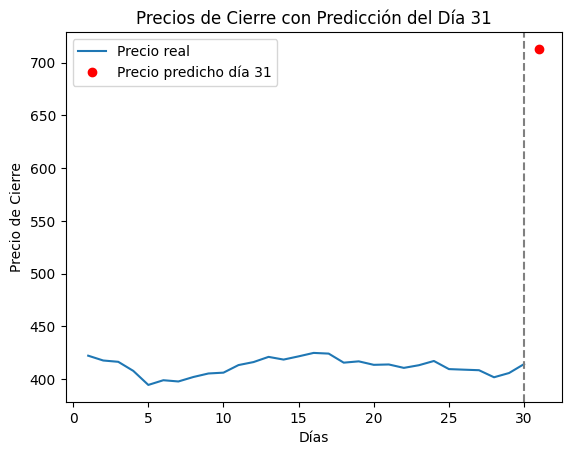

In [51]:
import numpy as np
import matplotlib.pyplot as plt

prices_real = df_test['Close'].values[-30:]

# Supongamos que 'prices_real' contiene los precios reales no escalados
P_30 = prices_real[-1]  # Precio de cierre del día 30 (último precio real)

# Calcula el precio de cierre predicho para el día 31
P_31_pred = P_30 * np.exp(log_return_pred_31)

# Lista de precios reales (últimos 30 días)

# Crea una lista de precios que incluya el precio predicho del día 31
prices_with_prediction = np.append(prices_real, P_31_pred)

print(f"Precio de cierre del día 30 (real): {P_30:.2f}")
print(f"Precio de cierre del día 31 (predicho): {P_31_pred:.2f}")

# Graficar los precios reales y el precio predicho para el día 31
plt.plot(range(1, 31), prices_real, label='Precio real')
plt.plot(31, P_31_pred, 'ro', label='Precio predicho día 31')  # Punto predicho
plt.axvline(x=30, color='gray', linestyle='--')  # Línea que separa datos reales de predichos
plt.legend()
plt.title("Precios de Cierre con Predicción del Día 31")
plt.xlabel("Días")
plt.ylabel("Precio de Cierre")
plt.show()



Buy and Hold Cumulative Return: 216.37%
LSTM Strategy Cumulative Return: 44.49%
LSTM Strategy Sharpe Ratio: 0.44
Buy and Hold Sharpe Ratio: 0.92


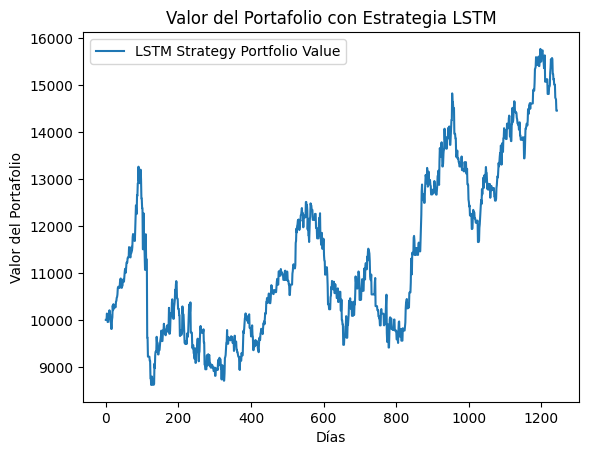

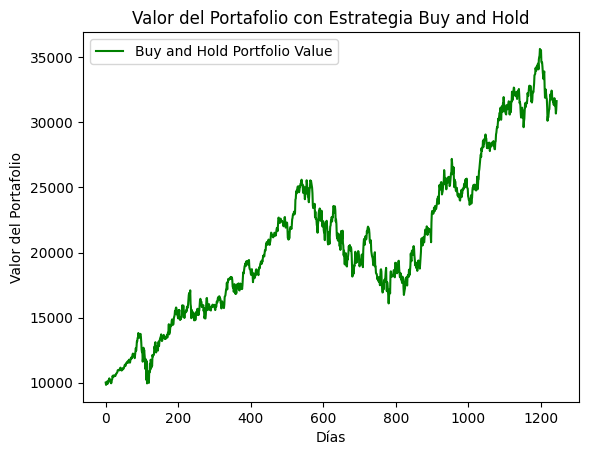

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Capital inicial y variables para el backtesting
initial_cash = 10000  # Capital inicial de $10,000
cash = initial_cash  # Efectivo disponible al comienzo
holdings = 0  # No tenemos acciones al comienzo
portfolio_value_lstm = []  # Lista para almacenar el valor diario del portafolio

# Recorrer el dataframe de predicciones para aplicar la estrategia de trading
for i in range(len(df_test) - 1):  # -1 porque no tenemos datos del último día para comparar con "mañana"
    current_price = df_test['Close'].iloc[i]  # Precio de cierre actual (día t)
    predicted_log_return = df_test['LSTM_Prediction'].iloc[i]  # log_return predicho para el día siguiente
    
    # Estimar el log_return predicho como cambio porcentual para ver si sube o baja
    predicted_next_price = current_price * np.exp(predicted_log_return)  # Calcula el precio predicho usando log_return

    # Si la predicción para el día siguiente es mayor que el precio de hoy, compramos
    if predicted_next_price > current_price and holdings == 0:
        holdings = cash / current_price  # Comprar tantas acciones como sea posible
        cash = 0  # Se invierte todo el efectivo

    # Si la predicción para el día siguiente es menor o igual al precio de hoy, vendemos si tenemos acciones
    elif predicted_next_price <= current_price and holdings > 0:
        cash = holdings * current_price  # Vendemos todas las acciones al precio de cierre actual
        holdings = 0  # Después de vender, no tenemos acciones

    # Guardar el valor del portafolio
    portfolio_value_lstm.append(cash + holdings * current_price)

# Calcular el valor del portafolio al final del período
portfolio_value_lstm = np.array(portfolio_value_lstm)
lstm_cumulative_return = (portfolio_value_lstm[-1] - initial_cash) / initial_cash  # Retorno acumulado

# Estrategia Buy and Hold: comprar al comienzo y mantener hasta el final
buy_and_hold_holdings = initial_cash / df_test['Close'].iloc[0]  # Compramos acciones al precio inicial
buy_and_hold_final_value = buy_and_hold_holdings * df_test['Close'].iloc[-1]  # Valor final de las acciones
buy_and_hold_cumulative_return = (buy_and_hold_final_value - initial_cash) / initial_cash  # Retorno acumulado

# Comparación de estrategias
print(f"Buy and Hold Cumulative Return: {buy_and_hold_cumulative_return * 100:.2f}%")
print(f"LSTM Strategy Cumulative Return: {lstm_cumulative_return * 100:.2f}%")

# Calcular ratios adicionales como el Sharpe Ratio para ambas estrategias
returns_lstm = portfolio_value_lstm[1:] / portfolio_value_lstm[:-1] - 1
returns_buy_and_hold = df_test['Close'].iloc[1:].values / df_test['Close'].iloc[:-1].values - 1

sharpe_ratio_lstm = np.mean(returns_lstm) / np.std(returns_lstm) * np.sqrt(252)  # Supone 252 días de trading en un año
sharpe_ratio_buy_and_hold = np.mean(returns_buy_and_hold) / np.std(returns_buy_and_hold) * np.sqrt(252)

print(f"LSTM Strategy Sharpe Ratio: {sharpe_ratio_lstm:.2f}")
print(f"Buy and Hold Sharpe Ratio: {sharpe_ratio_buy_and_hold:.2f}")

# Graficar el valor del portafolio con el tiempo para la estrategia LSTM
plt.plot(portfolio_value_lstm, label='LSTM Strategy Portfolio Value')
plt.title("Valor del Portafolio con Estrategia LSTM")
plt.xlabel("Días")
plt.ylabel("Valor del Portafolio")
plt.legend()
plt.show()

# Graficar el valor del portafolio de Buy and Hold para comparación
buy_and_hold_portfolio_value = df_test['Close'].values * buy_and_hold_holdings
plt.plot(buy_and_hold_portfolio_value, label='Buy and Hold Portfolio Value', color='green')
plt.title("Valor del Portafolio con Estrategia Buy and Hold")
plt.xlabel("Días")
plt.ylabel("Valor del Portafolio")
plt.legend()
plt.show()
